# Model Development and Apparent Validation

In [ ]:
source("notebooks/initialize-data-analysis.r")


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

# Penalized Likelihood Methods

## Backwards Stepwise Logistic Regression

In [ ]:
# library(StepReg)
# run_stepwise_logit <- function(data, formula) {
#   stepwiseLogit(
#     formula,
#     data = data,
#     include = NULL,
#     selection = "backward",
#     select = "AIC"
#   )
# }

# stepwise_model <- data_patient_complete |>
#   select(all_of(predictor_list), flag_ADR_TP_ID) |>
#   run_stepwise_logit(
#     formula = flag_ADR_TP_ID ~ .
#   )

# stepwise_model |> summary()


In [ ]:
run_step_AIC <- function(data, formula) {
  MASS::stepAIC(
    glm(
      formula = formula,
      data = data
    ),
    direction = "backward",
    trace = FALSE
  )
}

stepwise_model <- data_patient_complete |>
  select(all_of(predictor_list), flag_ADR_TP_ID) |>
  run_step_AIC(
    formula = flag_ADR_TP_ID ~ .
  )

stepwise_model$coefficients |> length()


[1] 18

Results: Stepwise algorithm selected 17 predictors.

## LASSO Variable Selection

In [ ]:
library(glmnet)


Loading required package: Matrix


Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack

Loaded glmnet 4.1-8

[1] 25

Results: LASSO algorithm selected 22-25 predictors.

Comment: Penalized likelihood methods have comparable predictive performance to Bayesian methods \[citation needed\], but select many more predictors.

# Bayesian Model Selection

                         P(B != 0 | Y)   model 1      model 2       model 3
Intercept                  1.000000000    1.0000    1.0000000    1.00000000
patient_age                0.779076539    1.0000    1.0000000    1.00000000
patient_sexTRUE            0.005550596    0.0000    0.0000000    0.00000000
LZD_dose_per_weight        0.004264025    0.0000    0.0000000    0.00000000
baseline_CLCR              0.323794156    0.0000    0.0000000    0.00000000
dept_ERTRUE                0.004444790    0.0000    0.0000000    0.00000000
dept_ICUTRUE               0.010969601    0.0000    0.0000000    0.00000000
baseline_HGB               0.336310194    1.0000    0.0000000    0.00000000
baseline_WBC               0.016686661    0.0000    0.0000000    0.00000000
baseline_PLT               1.000000000    1.0000    1.0000000    1.00000000
LZD_duration               0.999726142    1.0000    1.0000000    1.00000000
invasive_ETITRUE           0.126034016    0.0000    0.0000000    0.00000000
invasive_CVC

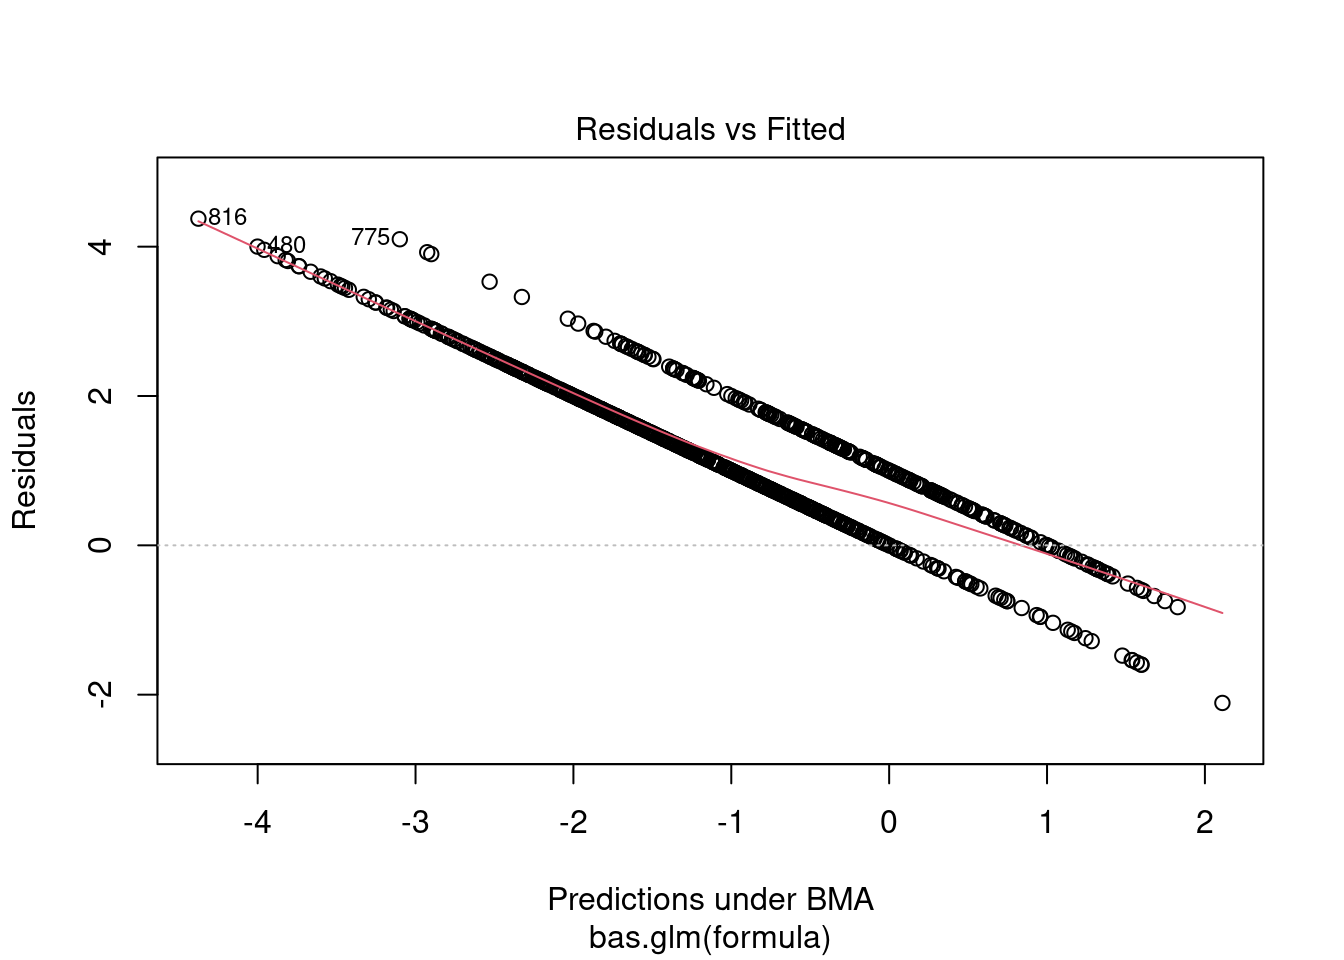

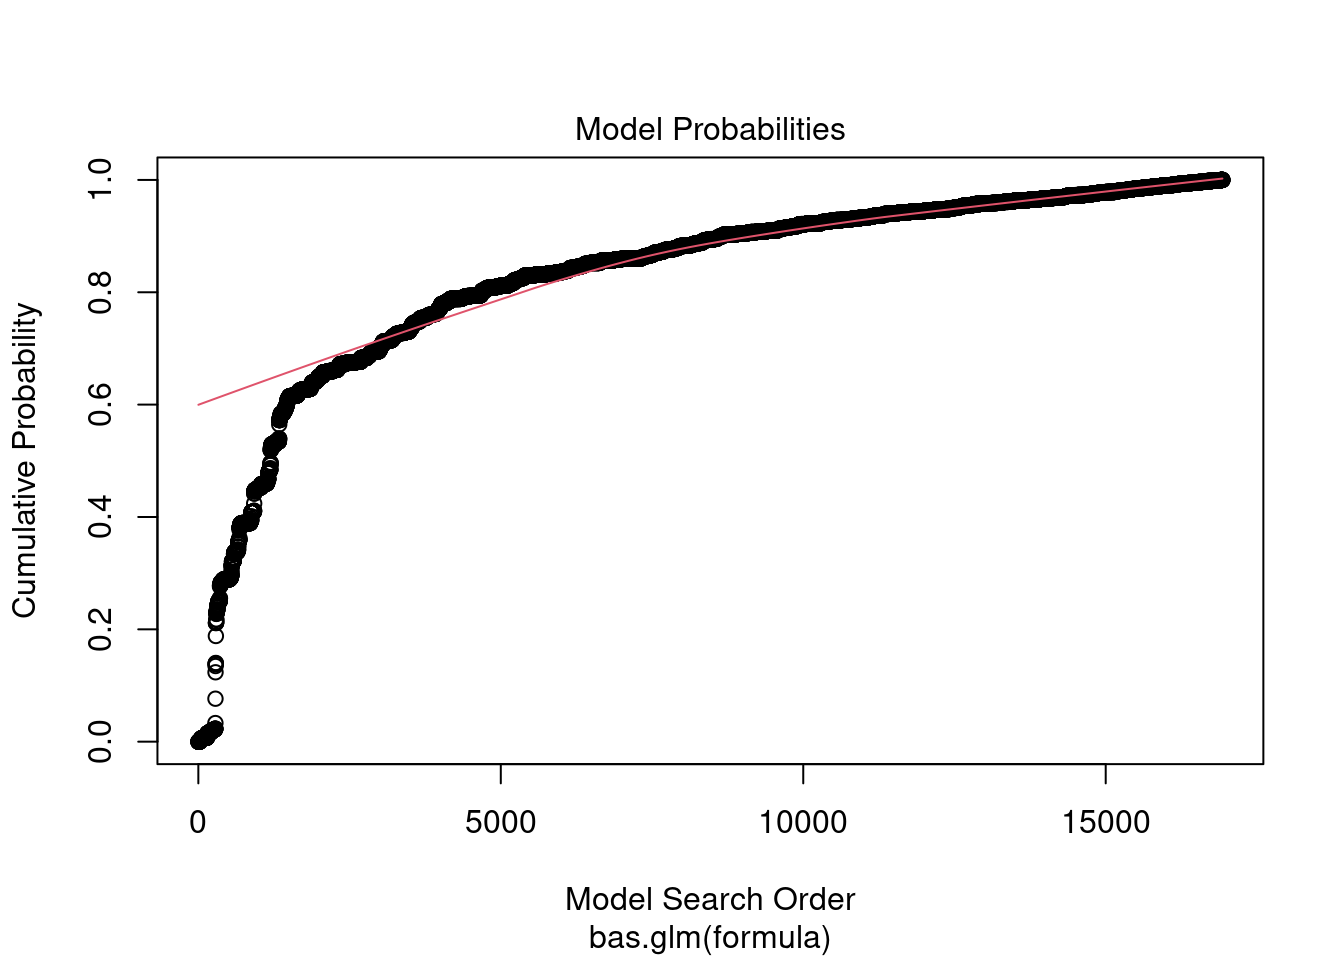

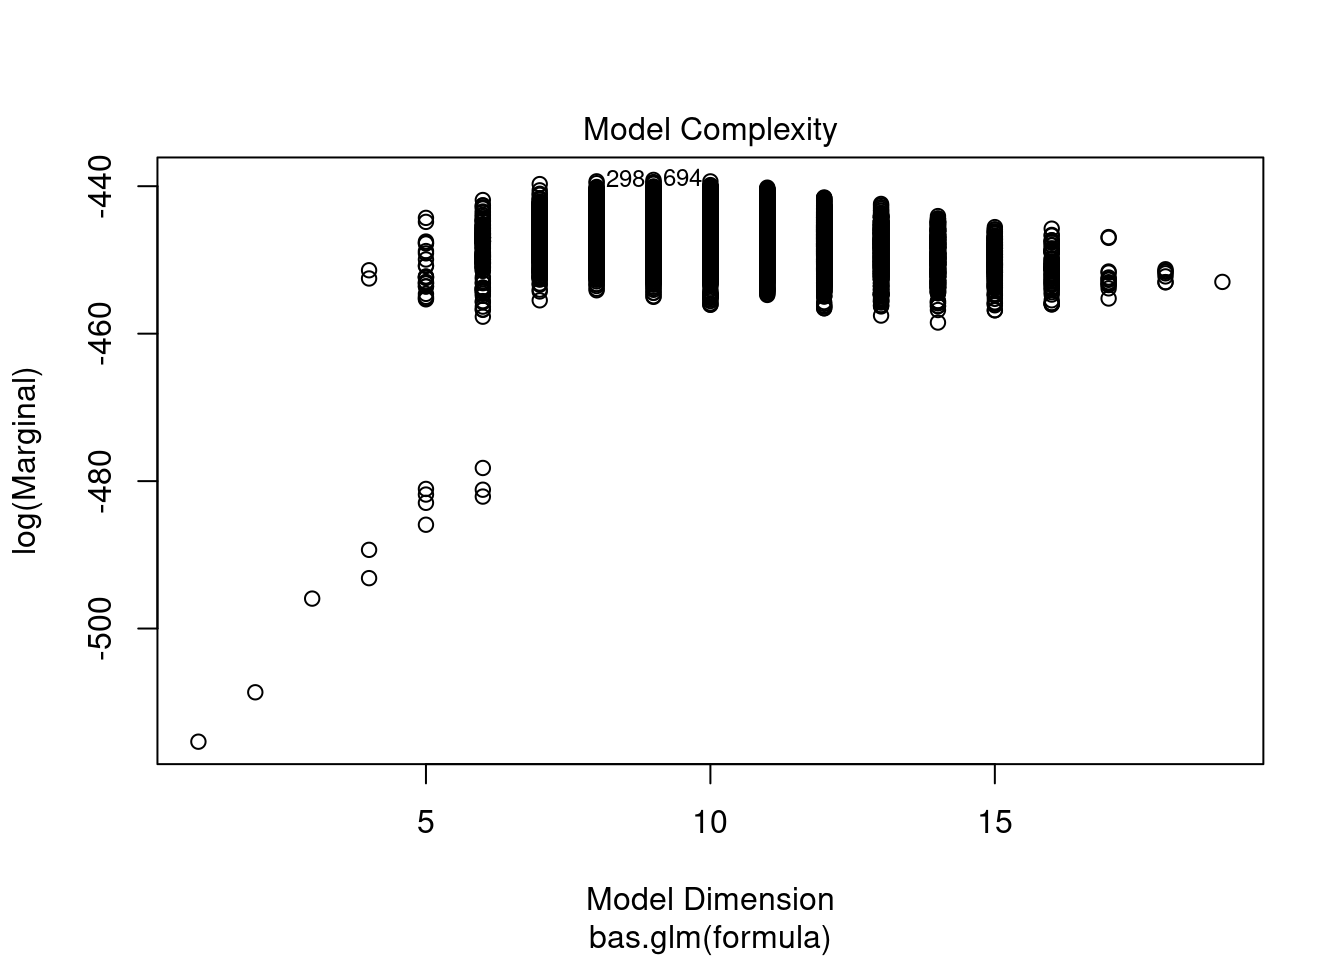

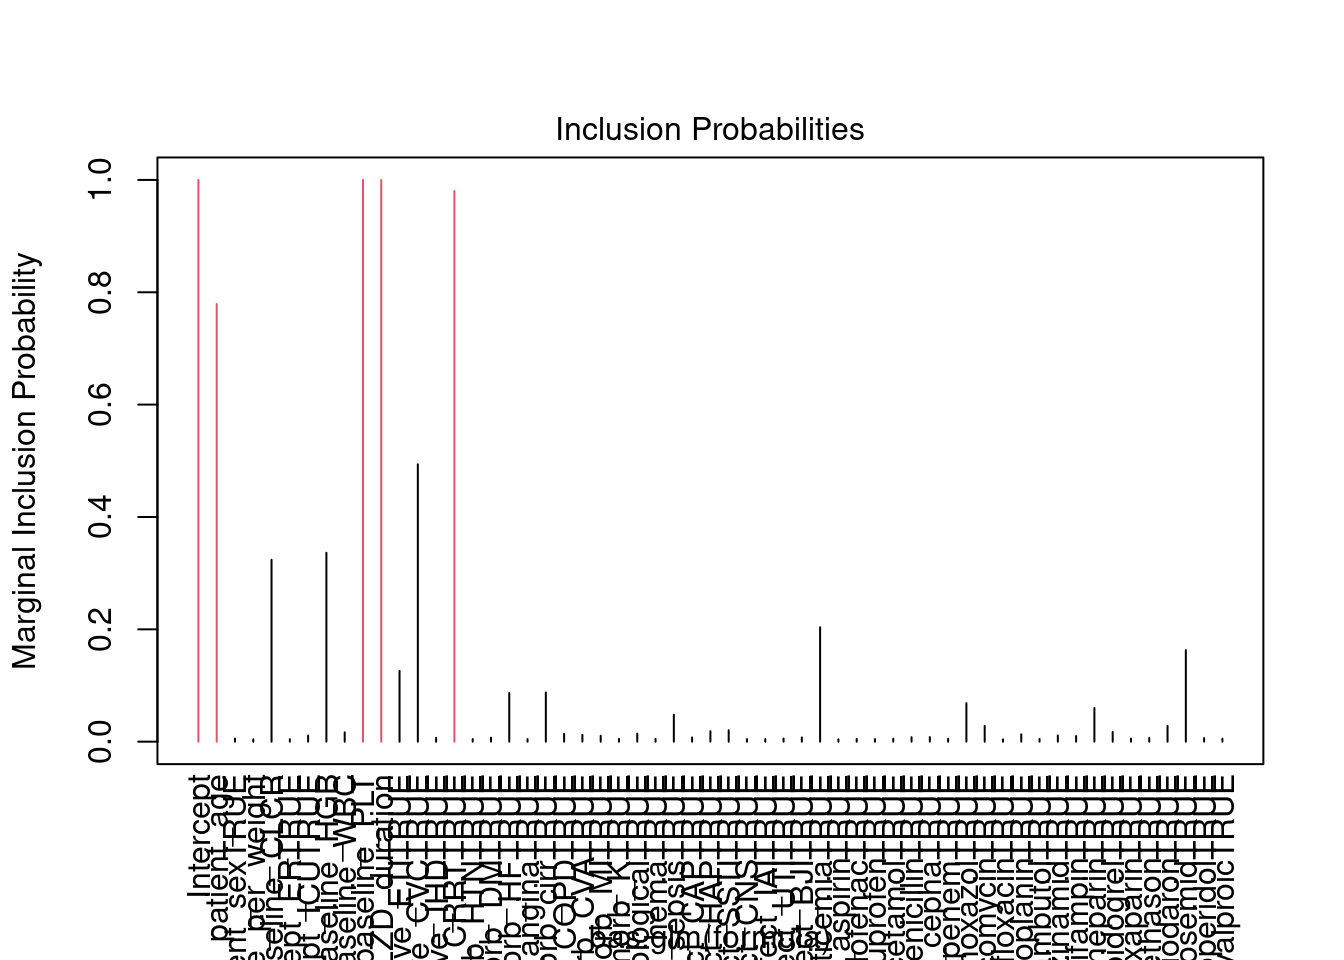

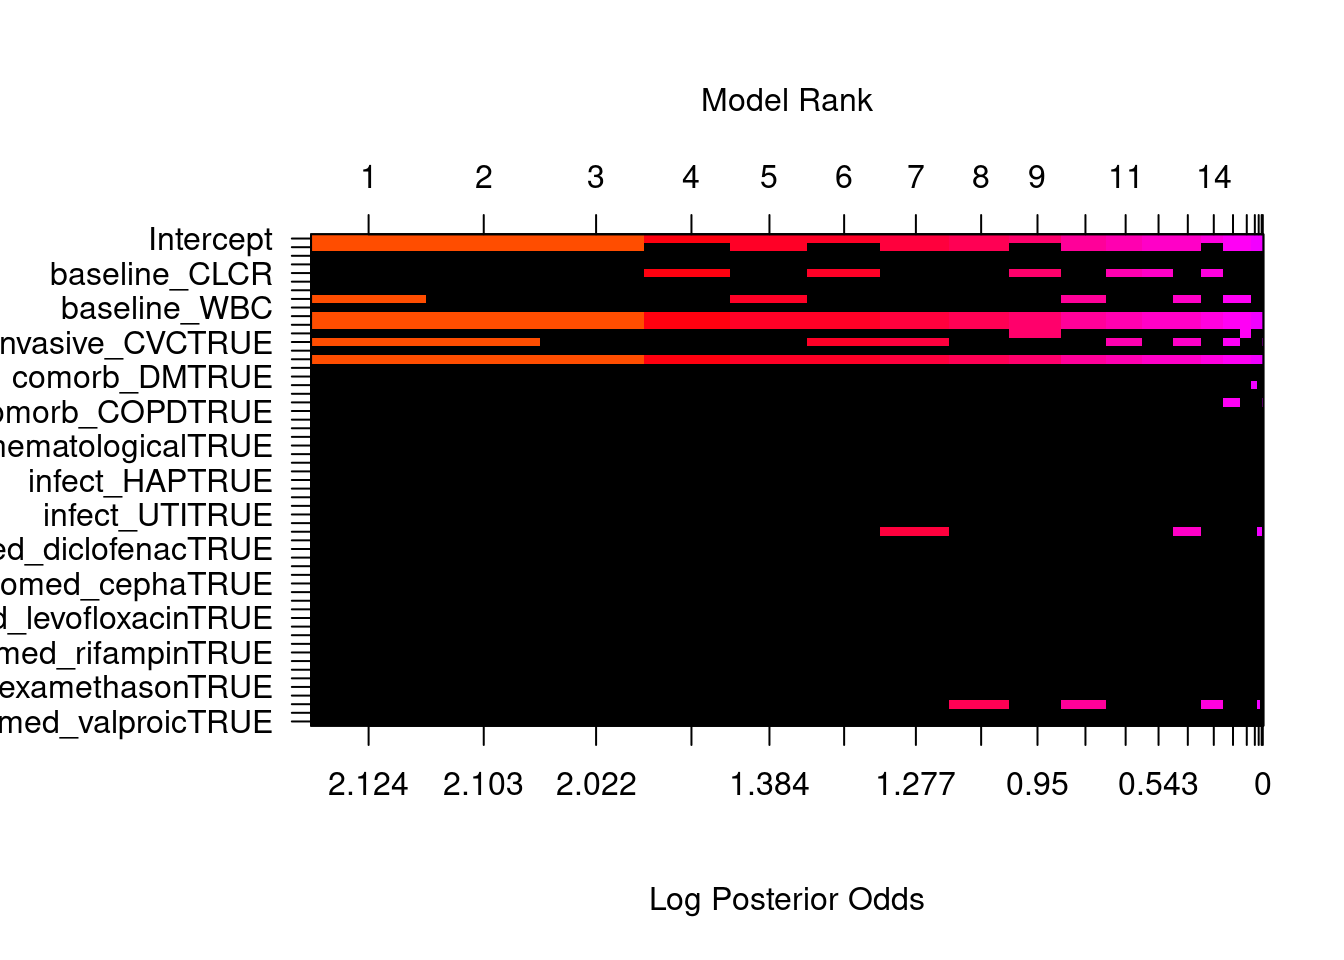

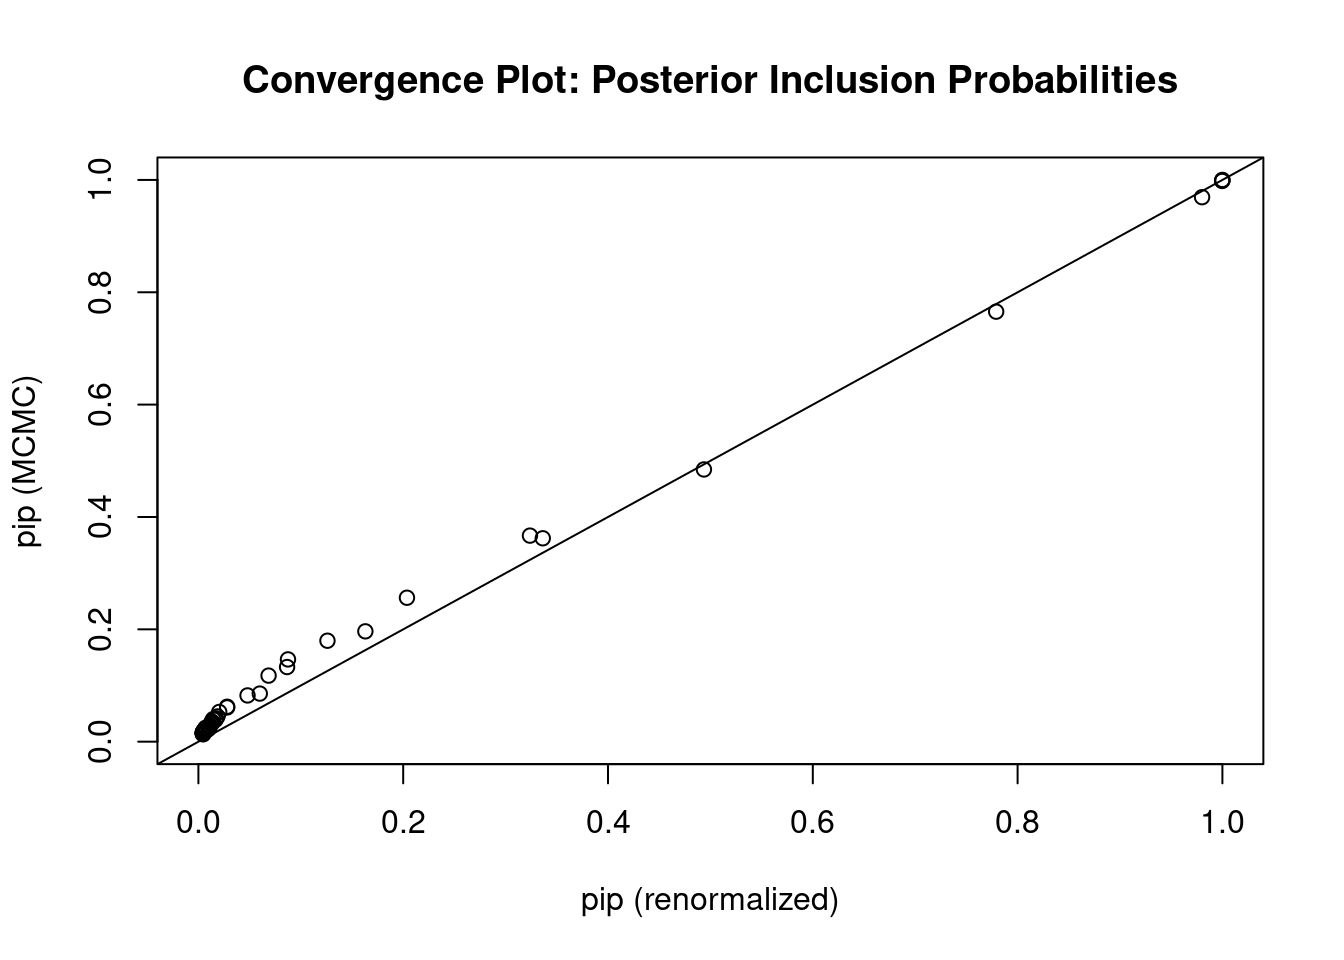

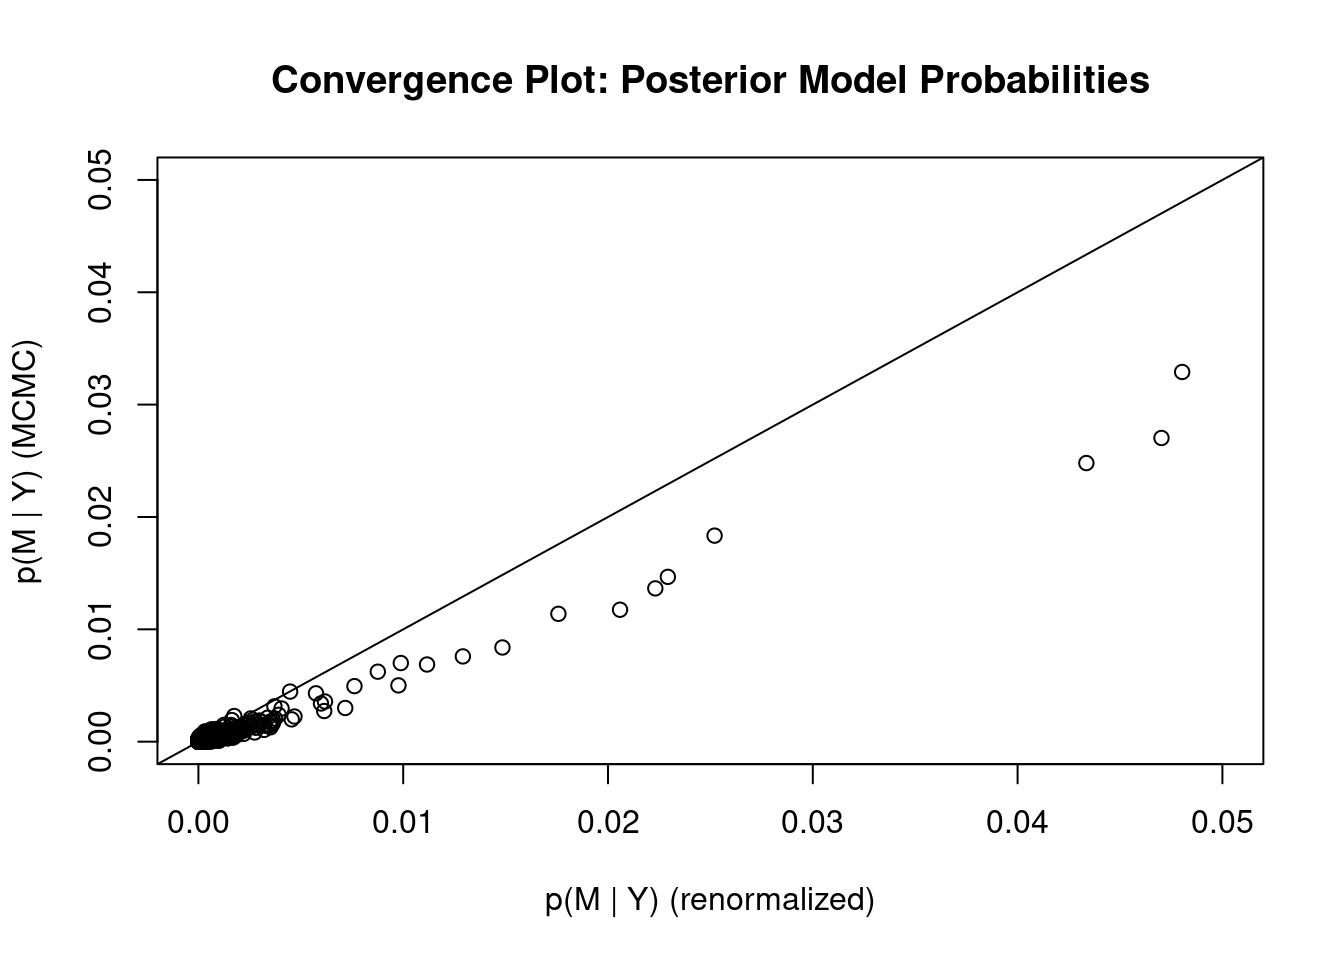

In [ ]:
multi_model <- data_patient_complete |>
  select(all_of(predictor_list), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = ~1
  )

summary(multi_model)


In [ ]:
library(tidymodels)


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5      ✔ rsample      1.2.0 
✔ dials        1.2.1      ✔ tune         1.2.0 
✔ infer        1.0.6      ✔ workflows    1.1.4 
✔ modeldata    1.3.0      ✔ workflowsets 1.1.0 
✔ parsnip      1.2.0      ✔ yardstick    1.3.0 
✔ recipes      1.0.10     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ Matrix::expand()  masks tidyr::expand()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ Matrix::pack()    masks tidyr::pack()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
✖ Matrix::unpack()  masks tidyr::unpack()
✖ recipes::update() masks Matrix::update(), stats::update()
• Search for functions across packages at https://www.tidymodels.org/find/

# Check Model Assumptions

## Linearity

Visual check of linearity assumption using partial-residual plots (component+residual plots).

Blue dashed line: linear fit of the partial residuals.

Red line: smoothed conditional mean

The lines should be close together and the red line should be linear.

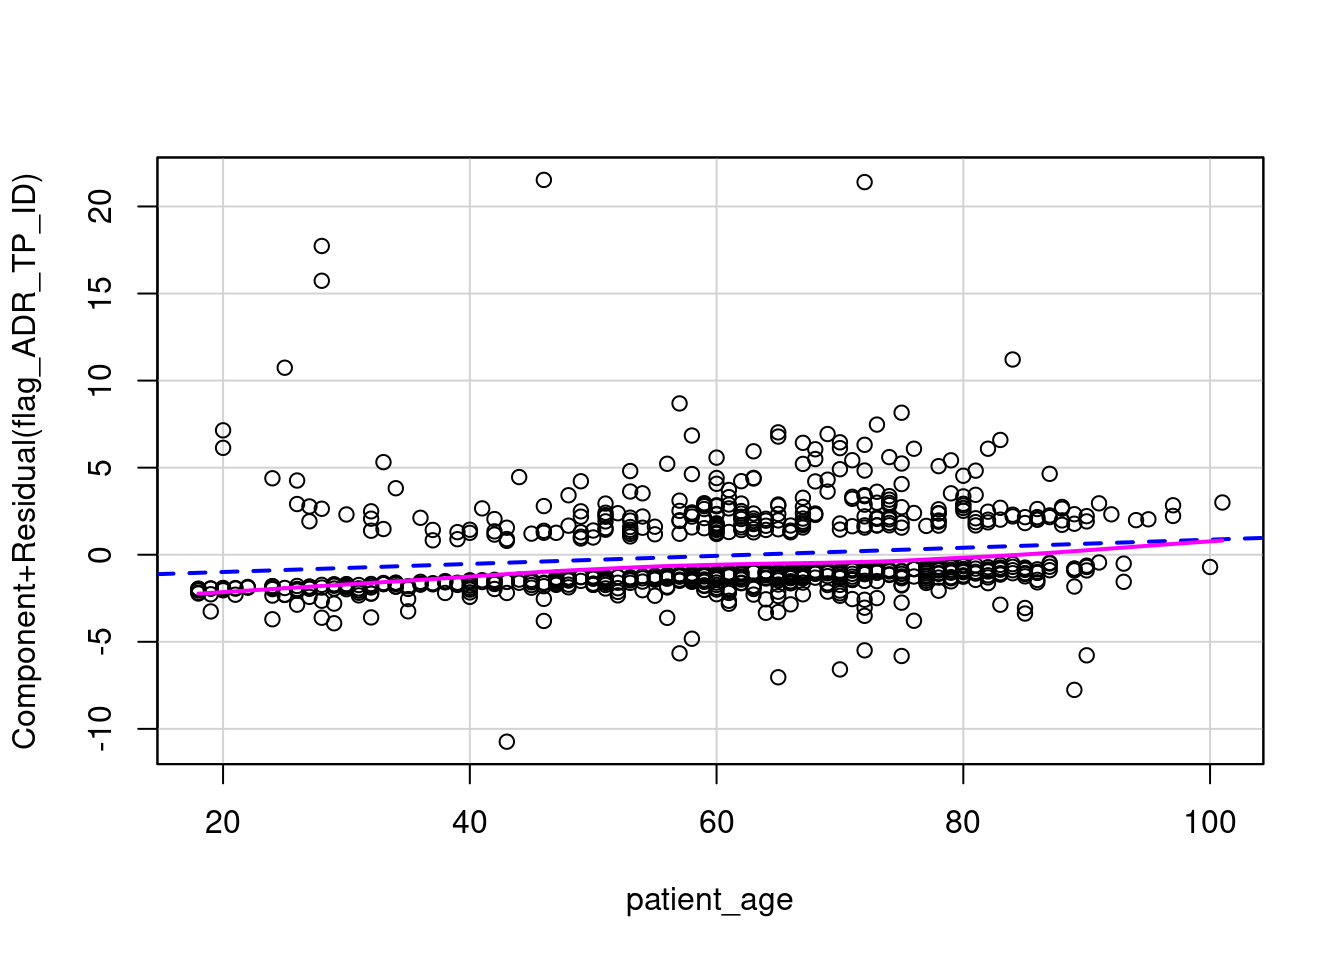

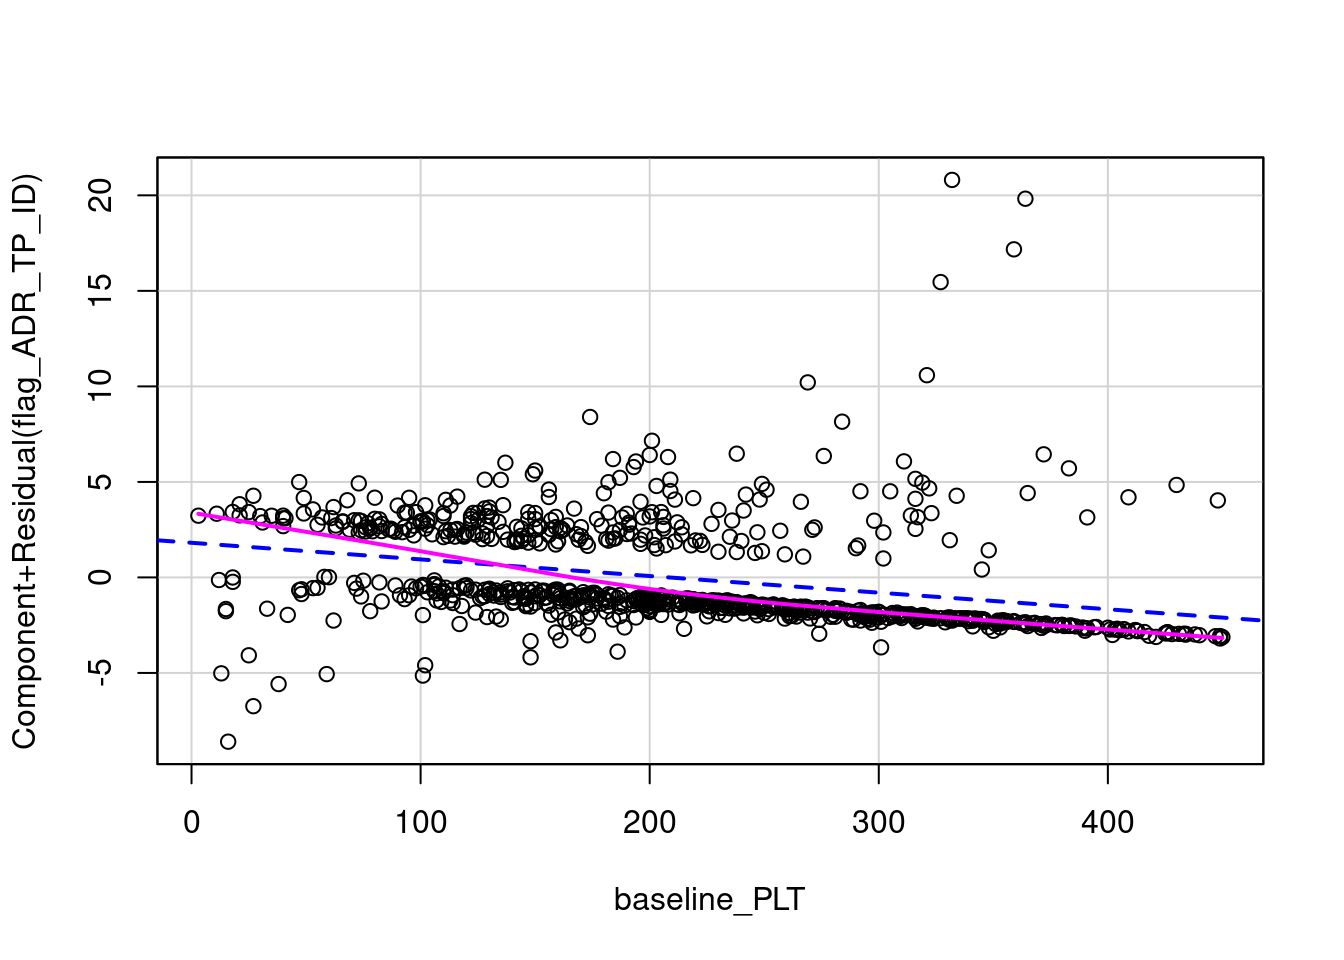

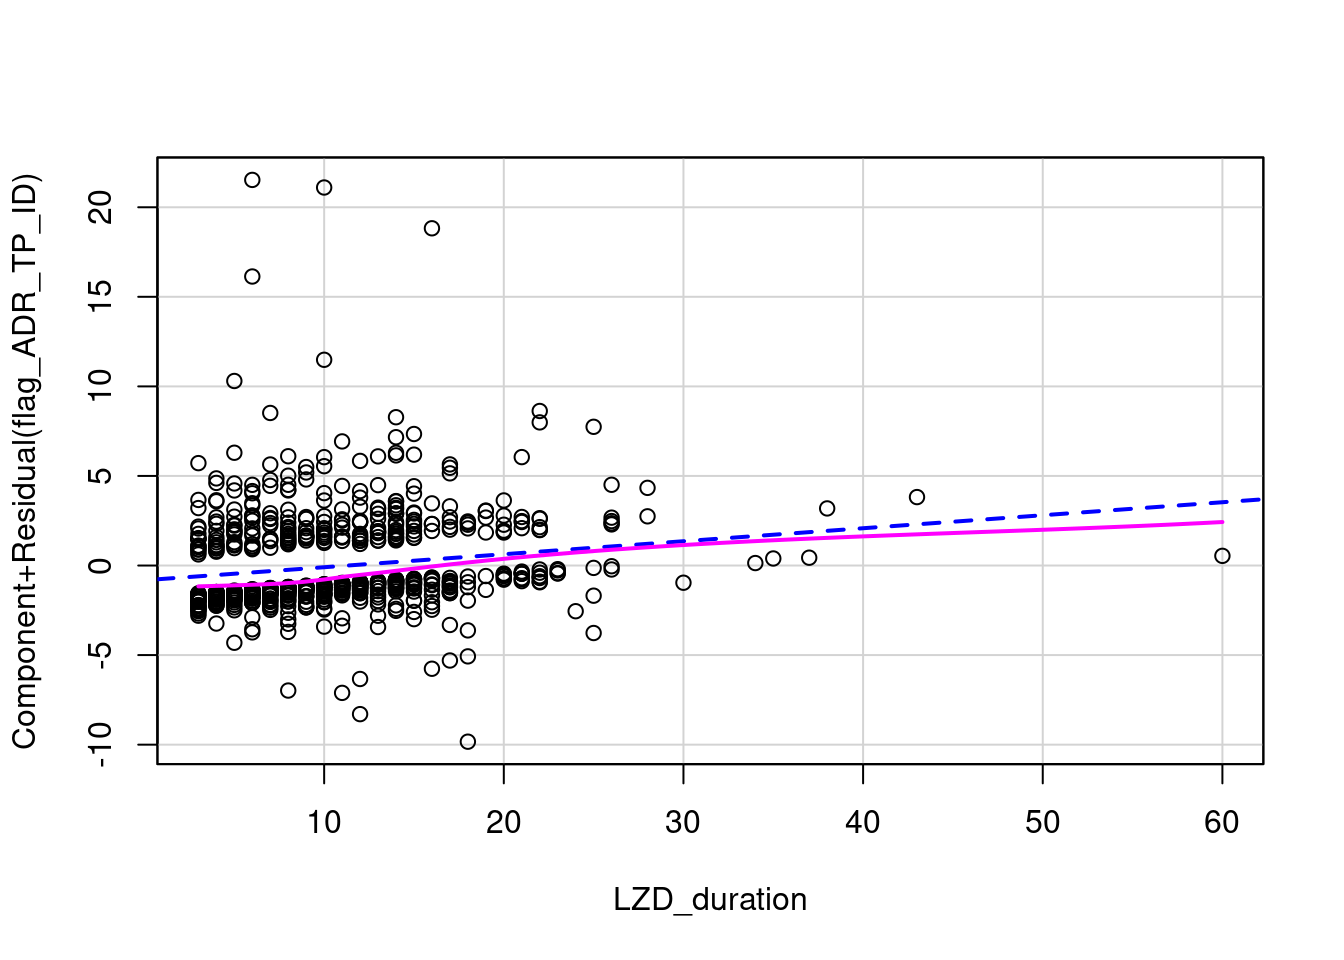

In [ ]:
car::crPlot(model_full$fit, variable = "patient_age")


Result: No obvious non-linearity in the partial-residual plots.

Visual check of linearity assumption using logit of predicted probabilities vs. continuous predictors values.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

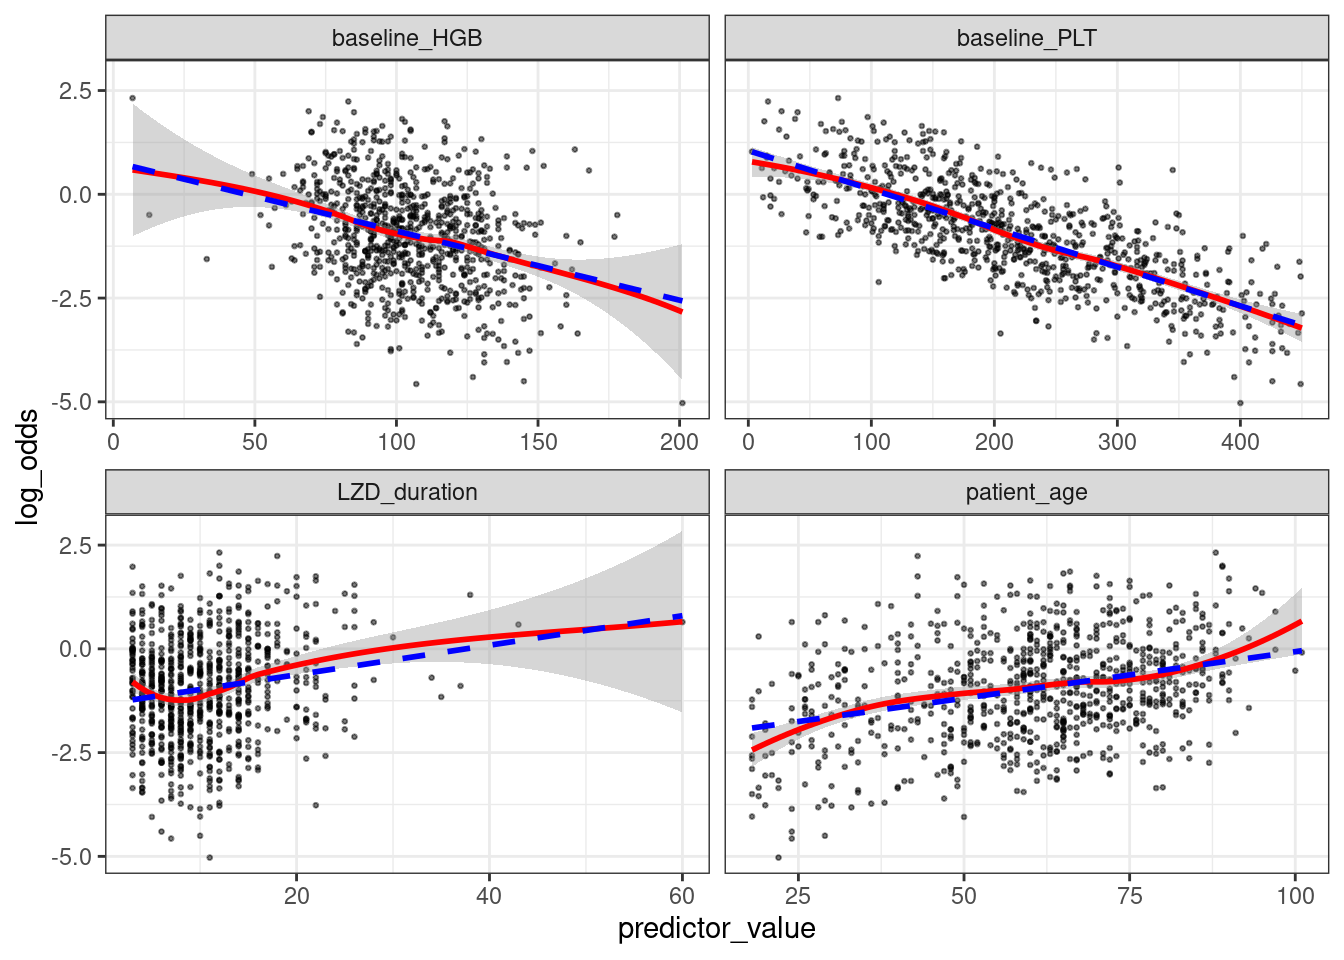

In [ ]:
data_patient_linear_check <- data_patient_complete |>
  select(all_of(multi_predict_HPM)) |>
  mutate(
    probabilities = predict(model_full$fit, data_patient_complete, type = "response"),
    log_odds = log(probabilities / (1 - probabilities))
  ) |>
  select_if(is.numeric) |>
  gather(key = "predictors", value = "predictor_value", -log_odds, -probabilities)

ggplot(data_patient_linear_check, aes(y = log_odds, x = predictor_value)) +
  geom_point(size = 0.5, alpha = 0.5) +
  geom_smooth(method = "loess", color = "red") +
  geom_smooth(method = "lm", linetype = "dashed", color = "blue", se = FALSE) +
  theme_bw() +
  facet_wrap(~predictors, scales = "free_x")


## No Multicollinearity

VIFs from the coefficient estimates should be less than 5 and as close to 1 as possible.

In [ ]:
car::vif(model_full$fit)


  patient_age  baseline_HGB  baseline_PLT  LZD_duration  invasive_CVC 
     1.047767      1.015409      1.094139      1.102152      1.136600 
invasive_CRRT 
     1.129723 

Result: VIFs are all less than 5 and close to 1.

## No Outlier Effects

Visual check from influence plot.

Individual observations should not have too much influence on the model.

Influence plot:

-   x-axis: Extreme values (Hat-values)
-   y-axis: Leverage (Studentized residuals)
-   Size of points: Cook’s distance

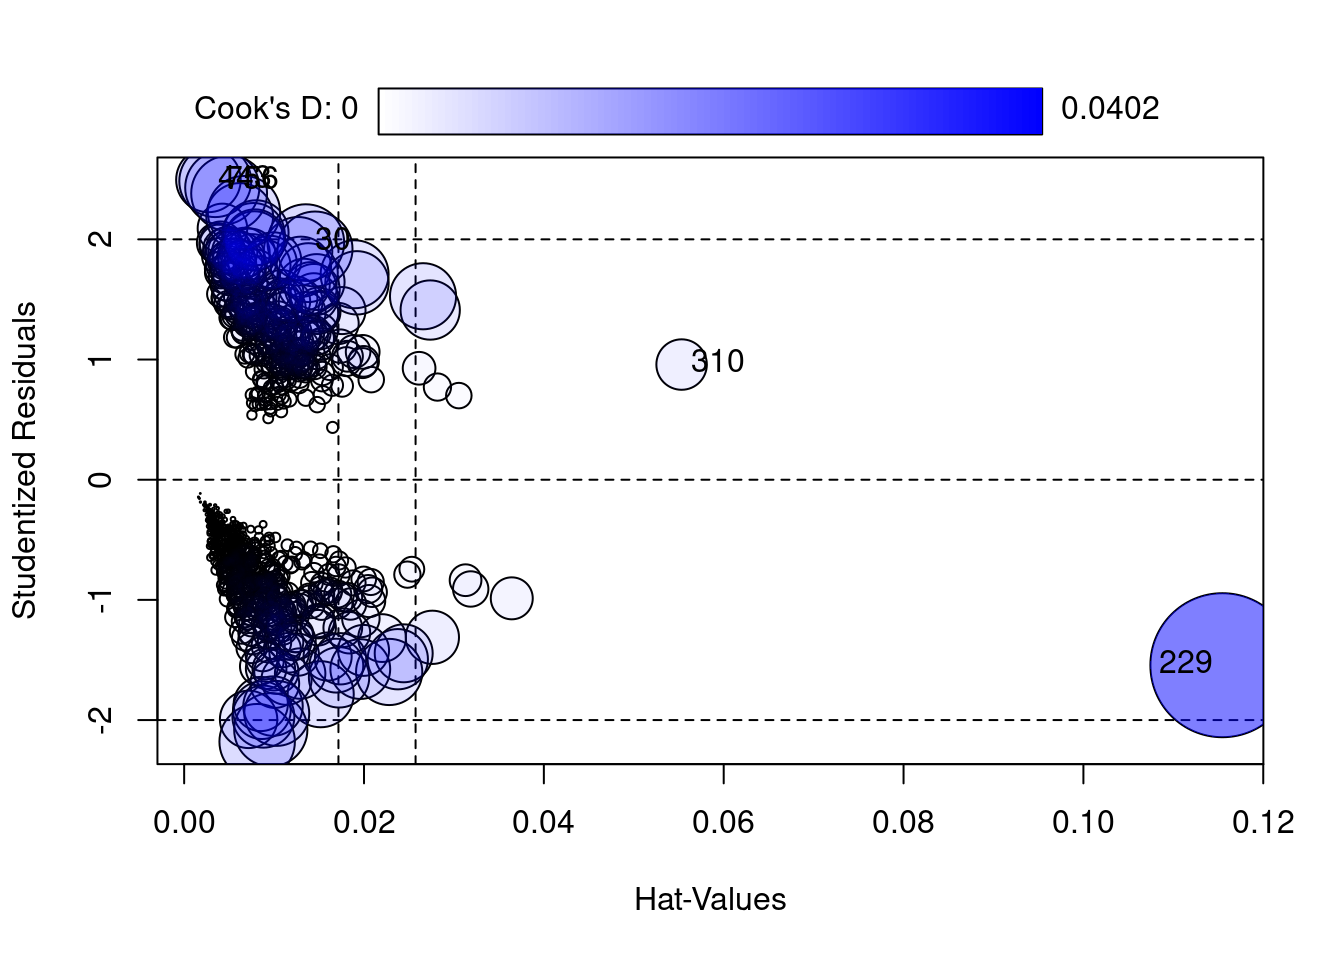

      StudRes         Hat       CookD
30   1.972941 0.013530192 0.011386152
229 -1.543583 0.115456843 0.040187659
310  0.958262 0.055317911 0.004933167
443  2.494706 0.002698824 0.008077000
756  2.484277 0.003456496 0.010011110

In [ ]:
car::influencePlot(model_full$fit)


Result: Influential observations identified.

DONE: Investigate observations 292, 301, 335, 364, 504, 634.

Investigation result:

-   invasive_CVC: 5/6
-   comed_furosemid: 3/6
-   infect_septicemia: 3/6

invasive_CVC might be a predictor.

In [ ]:
# data_patient_complete |>
#   slice(c(292, 301, 335, 364, 504, 634)) |> summary()


# Model Performance

In [ ]:
library(CalibrationCurves)


Loading required package: rms

Loading required package: Hmisc


Attaching package: 'Hmisc'

The following object is masked from 'package:parsnip':

    translate

The following objects are masked from 'package:dplyr':

    src, summarize

The following objects are masked from 'package:base':

    format.pval, units

In [ ]:
save(model_full, file = "data/model-performance/model-full.rda")
